# Data preparation and cleaning



### Imports for the whole project

In [43]:
import sqlite3, gc
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from textblob import TextBlob

### Connection to database

In [5]:
dataset_path = 'Customer_support_data.csv'
data = pd.read_csv(dataset_path)

data.rename(columns={'Customer Remarks': 'Customer_Remarks', 'CSAT Score': 'CSAT_Score'}, inplace=True)

# Print the first few rows of the dataset to confirm it's loaded correctly
print("First few rows of the dataset:")
print(data.head())

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('customer_support.db')
data.to_sql('customer_support', conn, if_exists='replace', index=False)
cur = conn.cursor()
print("\nSample rows from the 'customer_support' table:")
for row in cur.execute('SELECT * FROM customer_support LIMIT 5'):  # Adjust the LIMIT for more or fewer rows
    print(row)
conn.close()

# Confirm that the database operations are complete
print("\nDatabase operations completed successfully.")

First few rows of the dataset:
                              Unique id channel_name         category  \
0  7e9ae164-6a8b-4521-a2d4-58f7c9fff13f      Outcall  Product Queries   
1  b07ec1b0-f376-43b6-86df-ec03da3b2e16      Outcall  Product Queries   
2  200814dd-27c7-4149-ba2b-bd3af3092880      Inbound    Order Related   
3  eb0d3e53-c1ca-42d3-8486-e42c8d622135      Inbound          Returns   
4  ba903143-1e54-406c-b969-46c52f92e5df      Inbound     Cancellation   

                   Sub-category Customer_Remarks  \
0                Life Insurance              NaN   
1  Product Specific Information              NaN   
2             Installation/demo              NaN   
3        Reverse Pickup Enquiry              NaN   
4                    Not Needed              NaN   

                               Order_id order_date_time Issue_reported at  \
0  c27c9bb4-fa36-4140-9f1f-21009254ffdb             NaN  01/08/2023 11:13   
1  d406b0c7-ce17-4654-b9de-f08d421254bd             NaN  01/08/

### Checking null values within the db

In [6]:
conn = sqlite3.connect('customer_support.db')
customer_support_df = pd.read_sql_query("SELECT * FROM customer_support", conn)
print("DataFrame Information:")
print(customer_support_df.info())
print("\nDescriptive Statistics:")
print(customer_support_df.describe())
print("\nFirst 5 Rows of the DataFrame:")
print(customer_support_df.head())
print("\nCount of Null Values in Each Column:")
print(customer_support_df.isnull().sum())
num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")
total_rows = customer_support_df.shape[0]
print(f"Total number of rows: {total_rows}")
conn.close()

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer_Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14 

### Processing data in the database

In [7]:
customer_support_df['order_date_time'] = pd.to_datetime(customer_support_df['order_date_time'], dayfirst=True)
customer_support_df['Issue_reported at'] = pd.to_datetime(customer_support_df['Issue_reported at'], dayfirst=True)
customer_support_df['issue_responded'] = pd.to_datetime(customer_support_df['issue_responded'], dayfirst=True)
customer_support_df['Survey_response_Date'] = pd.to_datetime(customer_support_df['Survey_response_Date'], dayfirst=True)
customer_support_df['response_time_minutes'] = (customer_support_df['issue_responded'] - customer_support_df[
    'Issue_reported at']).dt.total_seconds() / 60
customer_support_df['order_hour_of_day'] = customer_support_df['order_date_time'].dt.hour
customer_support_df['issue_reported_hour_of_day'] = customer_support_df['Issue_reported at'].dt.hour
customer_support_df['order_day_of_week'] = customer_support_df[
    'order_date_time'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
customer_support_df['issue_reported_day_of_week'] = customer_support_df['Issue_reported at'].dt.dayofweek
customer_support_df['elapsed_days_to_survey'] = (customer_support_df['Survey_response_Date'] - customer_support_df[
    'order_date_time']).dt.total_seconds() / (
                                                            60 * 60 * 24)  # Calculate elapsed time from order to survey response (in days)

print("DataFrame Information:")
print(customer_support_df.info())
print("\nDescriptive Statistics:")
print(customer_support_df.describe())
print("\nFirst 5 Rows of the DataFrame:")
print(customer_support_df.head())
print("\nCount of Null Values in Each Column:")
print(customer_support_df.isnull().sum())
num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")
total_rows = customer_support_df.shape[0]
print(f"Total number of rows: {total_rows}")
conn.close()


C:\Users\matth\AppData\Local\Temp\ipykernel_15420\3325128775.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_support_df['Survey_response_Date'] = pd.to_datetime(customer_support_df['Survey_response_Date'], dayfirst=True)


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unique id                   85907 non-null  object        
 1   channel_name                85907 non-null  object        
 2   category                    85907 non-null  object        
 3   Sub-category                85907 non-null  object        
 4   Customer_Remarks            28742 non-null  object        
 5   Order_id                    67675 non-null  object        
 6   order_date_time             17214 non-null  datetime64[ns]
 7   Issue_reported at           85907 non-null  datetime64[ns]
 8   issue_responded             85907 non-null  datetime64[ns]
 9   Survey_response_Date        85907 non-null  datetime64[ns]
 10  Customer_City               17079 non-null  object        
 11  Product_category            171

### Dropping the columns with high null values

In [8]:
customer_support_df.drop(columns=[
    'order_date_time',
    'order_hour_of_day',
    'order_day_of_week',
    'elapsed_days_to_survey',
    'Order_id',
    'Customer_City',
    'Item_price',
    'connected_handling_time',
    'Product_category'
], inplace=True)

# Print the remaining columns and the count of null values in each
print("Remaining columns and the number of null values in each:")
print(customer_support_df.isnull().sum())

num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")

Remaining columns and the number of null values in each:
Unique id                         0
channel_name                      0
category                          0
Sub-category                      0
Customer_Remarks              57165
Issue_reported at                 0
issue_responded                   0
Survey_response_Date              0
Agent_name                        0
Supervisor                        0
Manager                           0
Tenure Bucket                     0
Agent Shift                       0
CSAT_Score                        0
response_time_minutes             0
issue_reported_hour_of_day        0
issue_reported_day_of_week        0
dtype: int64
Number of rows with no null values: 28742


### Filtering the DF to include only rows with no missing value and creating a new db

In [9]:
complete_cases_df = customer_support_df.dropna()
conn = sqlite3.connect('cleaned_customer_support.db')
complete_cases_df.to_sql('cleaned_customer_support', conn, if_exists='replace', index=False)
conn.close()



In [10]:
conn = sqlite3.connect('cleaned_customer_support.db')
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_customer_support", conn)
print("Basic statistics of the cleaned database:")
print(cleaned_df.describe())
print("\nInformation about the DataFrame:")
cleaned_df.info()
conn.close()

Basic statistics of the cleaned database:
         CSAT_Score  response_time_minutes  issue_reported_hour_of_day  \
count  28742.000000           28742.000000                28742.000000   
mean       4.073238             130.186835                   14.456718   
std        1.560075             593.501462                    5.066173   
min        1.000000           -1437.000000                    0.000000   
25%        4.000000               2.000000                   11.000000   
50%        5.000000               5.000000                   15.000000   
75%        5.000000              29.000000                   19.000000   
max        5.000000            5742.000000                   23.000000   

       issue_reported_day_of_week  
count                28742.000000  
mean                     2.835050  
std                      1.958646  
min                      0.000000  
25%                      1.000000  
50%                      3.000000  
75%                      5.000000  
max

### Evaluating the sentiment score from the customer remarks column and adding it to the db

In [11]:
conn = sqlite3.connect('cleaned_customer_support.db')


def calculate_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return None


cleaned_df['sentiment_score'] = cleaned_df['Customer_Remarks'].apply(calculate_sentiment)
print(cleaned_df[['Customer_Remarks', 'sentiment_score']].head(50))
cleaned_df.to_sql('cleaned_customer_support', conn, if_exists='replace', index=False)

print(cleaned_df.columns)

conn.close()


                                     Customer_Remarks  sentiment_score
0                                           Very good         0.910000
1   Shopzilla app and it's all coustomer care serv...         0.910000
2                                            Very bad        -0.910000
3                                          Something          0.000000
4                                            All good         0.700000
5                                               Good          0.700000
6                                            Godd job         0.000000
7                 Issue not resolved pathetic service        -1.000000
8                                          Excellent          1.000000
9                                          Very good          0.910000
10              Give proper guidance to the customer          0.000000
11  Please highlight if the products cannot be ret...         0.000000
12                                  3000 rupees loss          0.000000
13  Pl

### Trying out some other sentiment score methods

In [12]:
# trying without specific model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


def calculate_bert_sentiment(text):
    if pd.isna(text):
        return 0  # Assume neutral sentiment for missing remarks
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**encoded_input)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # Assuming that the first class is negative and the second is positive
    positive_score = scores[:, 1].item()
    return positive_score


cleaned_df['bert_sentiment'] = cleaned_df['Customer_Remarks'].apply(calculate_bert_sentiment)

# Display the first few entries of the new sentiment scores
print(cleaned_df[['Customer_Remarks', 'bert_sentiment']].head())

# This time, trying a model that's been fine-tuned for sentiment analysis
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)


def calculate_bert_sentiment(text):
    if pd.isna(text):
        return None  # or 0 for neutral sentiment
    result = sentiment_pipeline(text[:512])
    return result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']


# Apply the function to the Customer_Remarks column
cleaned_df['bert_sentiment2'] = cleaned_df['Customer_Remarks'].apply(calculate_bert_sentiment)

# Show the first few entries of the new sentiment scores
print(cleaned_df[['Customer_Remarks', 'bert_sentiment']].head())
# Drop the 'bert_sentiment' column since it was not a succes for both models
cleaned_df.drop(columns=['bert_sentiment'], inplace=True)
cleaned_df.drop(columns=['bert_sentiment2'], inplace=True)
# Display the DataFrame to confirm the column is dropped
print(cleaned_df.columns)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                    Customer_Remarks  bert_sentiment
0                                          Very good        0.482368
1  Shopzilla app and it's all coustomer care serv...        0.511377
2                                           Very bad        0.470942
3                                         Something         0.468955
4                                           All good        0.476021

                                    Customer_Remarks  bert_sentiment
0                                          Very good        0.482368
1  Shopzilla app and it's all coustomer care serv...        0.511377
2                                           Very bad        0.470942
3                                         Something         0.468955
4                                           All good        0.476021
Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer_Remarks', 'Issue_reported at', 'issue_responded',
       'Survey_response_Date', 'Agent_na

# Balancing database CSAT score distributions

In [20]:
# Function to calculate sentiment score
def calculate_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return None

def balance_data_with_resampling(ratio_over, ratio_under, output_db_filename):
    conn = sqlite3.connect('cleaned_customer_support.db')
    data = pd.read_sql_query("SELECT * FROM cleaned_customer_support", conn)
    conn.close()

    # Drop sentiment_score before resampling, as it doesn't make sense for synthetic data
    if 'sentiment_score' in data.columns:
        data = data.drop(columns=['sentiment_score'])

    # Identify non-numerical columns
    non_numerical_cols = data.select_dtypes(include=['object']).columns
    original_to_encoded_cols = {}
    for col in non_numerical_cols:
        encoded_cols = [f"{col}_{value}" for value in data[col].unique()]
        original_to_encoded_cols[col] = encoded_cols
    # Apply one-hot encoding to non-numerical columns
    data = pd.get_dummies(data, columns=non_numerical_cols)
    X = data.drop('CSAT_Score', axis=1)
    y = data['CSAT_Score'].astype(int)

    # Split the data into smaller batches
    batch_size = 10000
    X_batches = [X[i:i + batch_size] for i in range(0, len(X), batch_size)]
    y_batches = [y[i:i + batch_size] for i in range(0, len(y), batch_size)]
 
    over = SMOTE(sampling_strategy=ratio_over, random_state=42)
    under = RandomUnderSampler(sampling_strategy=ratio_under, random_state=42)
    resample_pipeline = Pipeline(steps=[('o', over), ('u', under)])

    print("Desired Ratios for Oversampling:")
    for class_label, ratio in desired_ratio.items():
        print(f"Class {class_label}: {ratio}")
    print("Desired Ratios for Undersampling:")
    for class_label, ratio in undersampling_ratio.items():
        print(f"Class {class_label}: {ratio}")
    # Adding the batches one by one 
    batch_num = 0
    resampled_batches = []
    for X_batch, y_batch in zip(X_batches, y_batches):
        batch_num += 1
        print("Batch Number:", batch_num)
        X_resampled, y_resampled = resample_pipeline.fit_resample(X_batch, y_batch)
        resampled_batches.append((X_resampled, y_resampled))
        del X_resampled, y_resampled
        gc.collect()

    balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns) for X_resampled, _ in resampled_batches])
    balanced_data['CSAT_Score'] = pd.concat([pd.Series(y_resampled) for _, y_resampled in resampled_batches],
                                            ignore_index=True)
    #Reverting to original values
    reverted_categorical_cols = pd.DataFrame()
    for col in non_numerical_cols:
        encoded_cols = [c for c in balanced_data.columns if c.startswith(col + '_')]
        reverted_col = balanced_data[encoded_cols].idxmax(axis=1).apply(lambda x: x.rsplit('_', 1)[-1])
        reverted_categorical_cols[col] = reverted_col

    balanced_data = balanced_data.drop(columns=sum(original_to_encoded_cols.values(), []))
    balanced_data = pd.concat([balanced_data, reverted_categorical_cols], axis=1)
    balanced_data = balanced_data[balanced_data['response_time_minutes'] >= 0]
    balanced_data['sentiment_score'] = balanced_data['Customer_Remarks'].apply(calculate_sentiment)
    conn = sqlite3.connect(output_db_filename)
    balanced_data.to_sql('balanced_customer_support', conn, if_exists='replace', index=False)
    conn.close()

    print("Balanced dataset saved to 'balance_customer_support.db'.")
    
num_batches =3
original_counts = {
    1: 5348,
    2: 394,
    3: 730,
    4: 2605,
    5: 19679
}
desired_ratio = {
    2: int(original_counts[2] / 3 * 2.5),
    3: int(original_counts[3] / 3 * 2.3),
    4: int(original_counts[4] / 3 * 2)
}
undersampling_ratio = {
    1: int(original_counts[1] / 3 * 0.75),
    5: int(original_counts[5] / 3 * 0.65)
}

balance_data_with_resampling(ratio_over=desired_ratio, ratio_under=undersampling_ratio, output_db_filename='balance_customer_support.db')


Desired Ratios for Oversampling:
Class 2: 328
Class 3: 559
Class 4: 1736
Desired Ratios for Undersampling:
Class 1: 1337
Class 5: 4263
Batch Number: 1
Batch Number: 2
Batch Number: 3


C:\Users\matth\AppData\Local\Temp\ipykernel_27804\449603437.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_data['CSAT_Score'] = pd.concat([pd.Series(y_resampled) for _, y_resampled in resampled_batches],


Balanced dataset saved to 'balance_customer_support.db'.


#### Final CSAT score data distribution

In [21]:
conn = sqlite3.connect('balance_customer_support.db')
query = "SELECT CSAT_Score, COUNT(*) as count FROM balanced_customer_support GROUP BY CSAT_Score"
csat_distribution = pd.read_sql_query(query, conn)
conn.close()
print(csat_distribution)

   CSAT_Score  count
0           1   5828
1           2   1465
2           3   2580
3           4   5385
4           5   8420


# Random Forest and MLP Classification Models

#### Load the prepared data from the SQLite database.

In [51]:
conn = sqlite3.connect('balance_customer_support.db')
data = pd.read_sql_query("SELECT * FROM balanced_customer_support", conn)
conn.close()

#### Define target variable `y`.

In [52]:
y = data['CSAT_Score'].astype('category')  # Ensuring 'y' is a categorical type for stratification

#### Prepare the data using one-hot encoder to convert categorical features into numerical features and combine them.

In [53]:
# OneHotEncode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(
    data[['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager']])
encoded_feature_names = encoder.get_feature_names_out(
    ['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager'])

# Combine numerical and OneHotEncoded categorical features
X = pd.concat(
    [data[['issue_reported_hour_of_day', 'response_time_minutes', 'issue_reported_day_of_week', 'sentiment_score']],
     pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)], axis=1)

#### Split the data into training and testing sets with stratification

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Random Forest

#### Initialize hyperparameters and train Random Forest classifier

In [55]:
# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy',n_jobs=-1).fit(X_train, y_train)

#### Get the best model from grid search then make predictions.

In [56]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

#### Plot confusion matrix

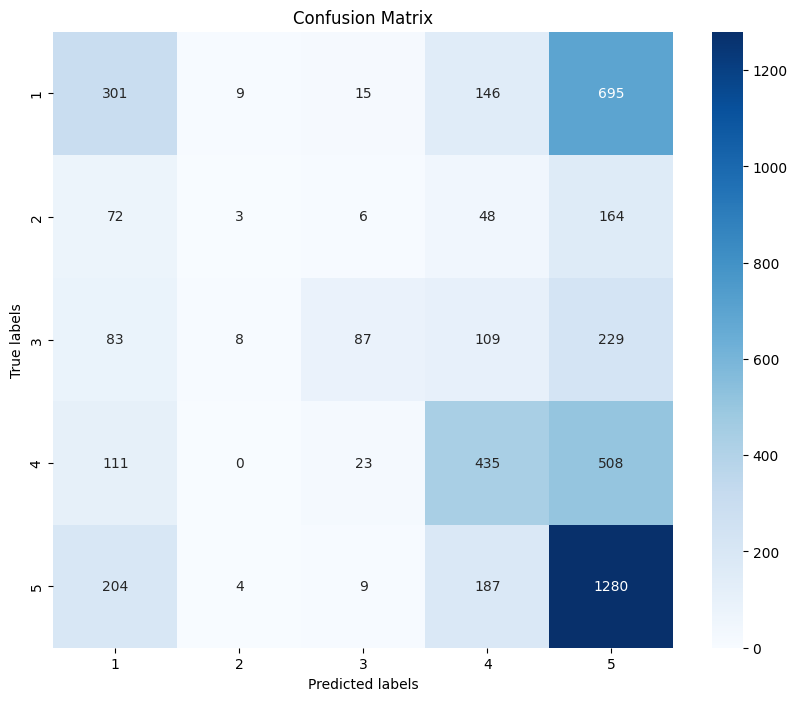

In [57]:
def plot_confusion_matrix(y_true, y_pred, class_labels=None):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=class_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
class_labels = [1, 2, 3, 4, 5]
plot_confusion_matrix(y_test, y_pred, class_labels)

#### Display the best Random Forest model's classification report

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.26      0.31      1166
           2       0.12      0.01      0.02       293
           3       0.62      0.17      0.27       516
           4       0.47      0.40      0.43      1077
           5       0.45      0.76      0.56      1684

    accuracy                           0.44      4736
   macro avg       0.41      0.32      0.32      4736
weighted avg       0.44      0.44      0.41      4736



In [59]:
# Print accuracy for each class
cm = confusion_matrix(y_test, y_pred)
correct_classifications = cm.diagonal()
support = cm.sum(axis=1)
class_accuracies = correct_classifications / support

for i, accuracy in enumerate(class_accuracies, start=1):
    print(f"Accuracy for class {i}: {accuracy:.2f}")

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {overall_accuracy:.2f}")

Accuracy for class 1: 0.26
Accuracy for class 2: 0.01
Accuracy for class 3: 0.17
Accuracy for class 4: 0.40
Accuracy for class 5: 0.76
Overall accuracy: 0.44


#### Display top 5 most important features for best Random Forest model for the balanced dataset

In [13]:
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_indices[:5]]
top_importances = feature_importances[sorted_indices[:5]]

print("\nTop 5 Important Features for the Best Model:\n")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")


Top 5 Important Features for the Best Model:

response_time_minutes: 0.1124
issue_reported_hour_of_day: 0.0999
issue_reported_day_of_week: 0.0979
sentiment_score: 0.0887
Sub-category_Reverse Pickup Enquiry: 0.0147


## Multi-Layered Perceptron

#### Define and train MLP classifier using set hyperparams.

In [60]:
param_grid = {
    'hidden_layer_sizes': [(100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500],
    'batch_size': [32, 64, 128],
    'early_stopping': [True],
    'n_iter_no_change': [10],
}

grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.0001],
                         'batch_size': [32, 64, 128], 'early_stopping': [True],
                         'hidden_layer_sizes': [(100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [500], 'n_iter_no_change': [10],
                         'solver': ['adam']})

#### Make predictions with the best MLP model

In [61]:
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

#### Generate MLP classification report

In [62]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.35      0.20      0.26      1166
           2       0.07      0.00      0.01       293
           3       0.33      0.16      0.21       516
           4       0.41      0.34      0.37      1077
           5       0.42      0.72      0.53      1684

    accuracy                           0.40      4736
   macro avg       0.32      0.28      0.27      4736
weighted avg       0.37      0.40      0.36      4736



#### Plot confusion matrix

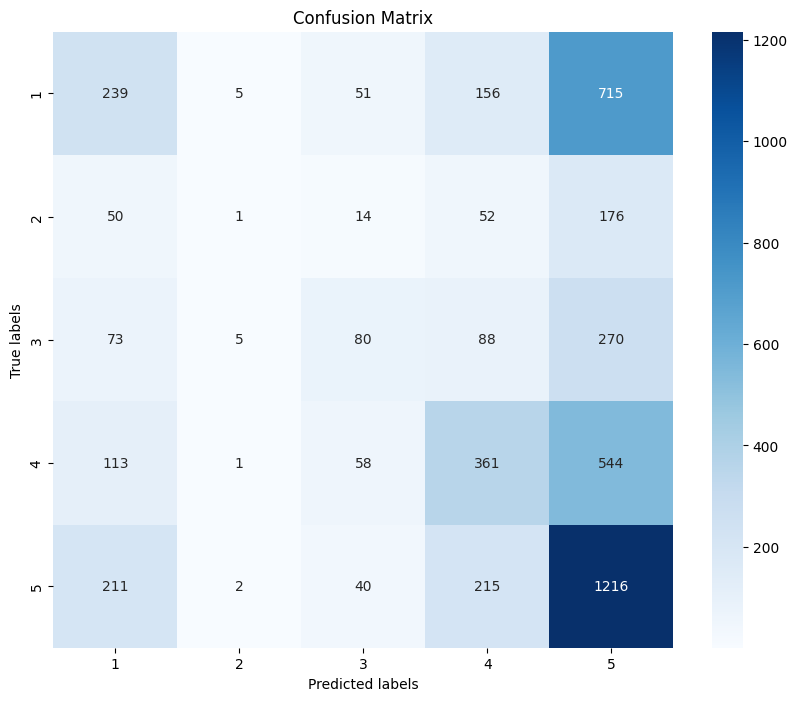

In [32]:
class_labels = y.cat.categories  # This will automatically extract the category labels
plot_confusion_matrix(y_test, y_pred, class_labels)

In [63]:
# Print accuracy for each class
cm = confusion_matrix(y_test, y_pred)
correct_classifications = cm.diagonal()
support = cm.sum(axis=1)
class_accuracies = correct_classifications / support

for i, accuracy in enumerate(class_accuracies, start=1):
    print(f"Accuracy for class {i}: {accuracy:.2f}")

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {overall_accuracy:.2f}")

Accuracy for class 1: 0.20
Accuracy for class 2: 0.00
Accuracy for class 3: 0.16
Accuracy for class 4: 0.34
Accuracy for class 5: 0.72
Overall accuracy: 0.40


# Trying to reach a more balanced Dataset

In [35]:
num_batches = 3
original_counts = {
    1: 5348,
    2: 394,   
    3: 730,
    4: 2605,
    5: 19679  
}
desired_ratio = {
    2: int(original_counts[2] / num_batches * 10),
    3: int(original_counts[3] / num_batches* 5.5),
    4: int(original_counts[4] /num_batches * 1.3)
}
undersampling_ratio = {
    1: int(original_counts[1] / num_batches* 0.45),
    5: int(original_counts[5] / num_batches * 0.15)
}
balance_data_with_resampling(desired_ratio,undersampling_ratio,"perfectly_balanced.db")

Desired Ratios for Oversampling:
Class 2: 1313
Class 3: 1460
Class 4: 1042
Desired Ratios for Undersampling:
Class 1: 802
Class 5: 983
Batch Number: 1
Batch Number: 2
Batch Number: 3


C:\Users\matth\AppData\Local\Temp\ipykernel_27804\449603437.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_data['CSAT_Score'] = pd.concat([pd.Series(y_resampled) for _, y_resampled in resampled_batches],


Balanced dataset saved to 'balance_customer_support.db'.


In [36]:
conn = sqlite3.connect('perfectly_balanced.db')
query = "SELECT CSAT_Score, COUNT(*) as count FROM balanced_customer_support GROUP BY CSAT_Score"
csat_distribution = pd.read_sql_query(query, conn)
conn.close()
print(csat_distribution)

   CSAT_Score  count
0           1   3200
1           2   3539
2           3   3023
3           4   2855
4           5   3524


# Loading the data from the perfectly balanced db

In [35]:
conn = sqlite3.connect('perfectly_balanced.db')
data = pd.read_sql_query("SELECT * FROM balanced_customer_support", conn)
conn.close()
y = data['CSAT_Score'].astype('category')
# OneHotEncode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(
    data[['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager']])
encoded_feature_names = encoder.get_feature_names_out(
    ['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager'])

# Combine numerical and OneHotEncoded categorical features
X = pd.concat(
    [data[['issue_reported_hour_of_day', 'response_time_minutes', 'issue_reported_day_of_week', 'sentiment_score']],
     pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Random Forest

In [36]:
# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy',n_jobs=-1).fit(X_train, y_train)

In [37]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

### Plot Confusion Matrix

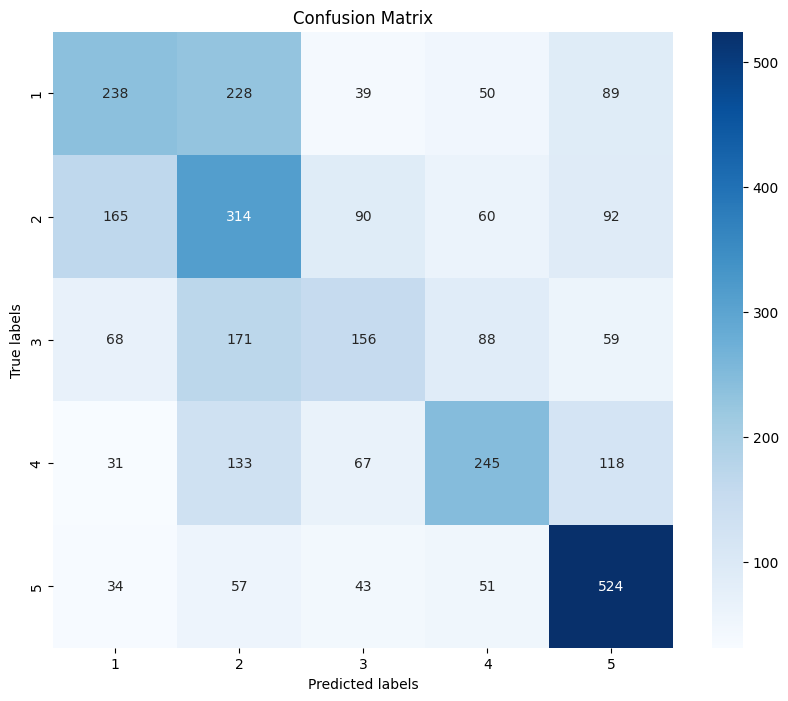

In [38]:
class_labels = [1, 2, 3, 4, 5]
plot_confusion_matrix(y_test, y_pred, class_labels)

### Classification report for RF

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.44      0.37      0.40       644
           2       0.35      0.44      0.39       721
           3       0.39      0.29      0.33       542
           4       0.50      0.41      0.45       594
           5       0.59      0.74      0.66       709

    accuracy                           0.46      3210
   macro avg       0.46      0.45      0.45      3210
weighted avg       0.46      0.46      0.45      3210



In [44]:
# Print accuracy for each class
cm = confusion_matrix(y_test, y_pred)
correct_classifications = cm.diagonal()
support = cm.sum(axis=1)
class_accuracies = correct_classifications / support

for i, accuracy in enumerate(class_accuracies, start=1):
    print(f"Accuracy for class {i}: {accuracy:.2f}")
    
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {overall_accuracy:.2f}")


Accuracy for class 1: 0.37
Accuracy for class 2: 0.44
Accuracy for class 3: 0.29
Accuracy for class 4: 0.41
Accuracy for class 5: 0.74
Overall accuracy: 0.46


#### Display top 5 most important features for best Random Forest model for the perfectly balanced dataset

In [42]:
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_indices[:5]]
top_importances = feature_importances[sorted_indices[:5]]

print("\nTop 5 Important Features for the Best Model:\n")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")


Top 5 Important Features for the Best Model:

response_time_minutes: 0.1062
issue_reported_day_of_week: 0.0845
issue_reported_hour_of_day: 0.0786
sentiment_score: 0.0771
Manager_Jennifer Nguyen: 0.0163


# MLP Classifier 

In [46]:
param_grid = {
    'hidden_layer_sizes': [(100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500],
    'batch_size': [32, 64, 128],
    'early_stopping': [True],
    'n_iter_no_change': [10],
}

grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.0001],
                         'batch_size': [32, 64, 128], 'early_stopping': [True],
                         'hidden_layer_sizes': [(100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [500], 'n_iter_no_change': [10],
                         'solver': ['adam']})

In [47]:
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

### Confusion Matrix for MLP

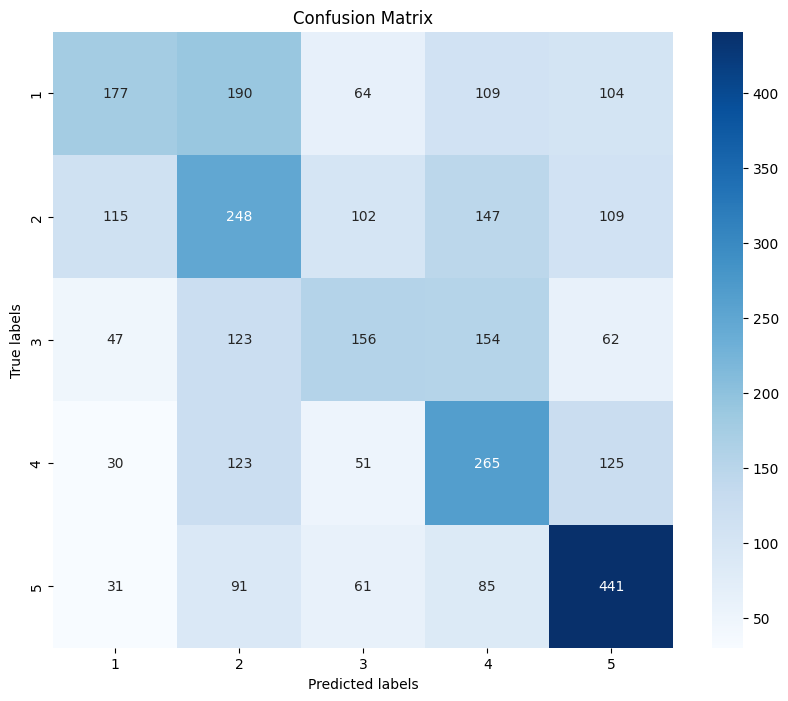

In [48]:
class_labels = y.cat.categories  # This will automatically extract the category labels
plot_confusion_matrix(y_test, y_pred, class_labels)

### Classification Report for MLP

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.44      0.27      0.34       644
           2       0.32      0.34      0.33       721
           3       0.36      0.29      0.32       542
           4       0.35      0.45      0.39       594
           5       0.52      0.62      0.57       709

    accuracy                           0.40      3210
   macro avg       0.40      0.39      0.39      3210
weighted avg       0.40      0.40      0.39      3210



In [50]:
# Print accuracy for each class
cm = confusion_matrix(y_test, y_pred)
correct_classifications = cm.diagonal()
support = cm.sum(axis=1)
class_accuracies = correct_classifications / support

for i, accuracy in enumerate(class_accuracies, start=1):
    print(f"Accuracy for class {i}: {accuracy:.2f}")

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {overall_accuracy:.2f}")

Accuracy for class 1: 0.27
Accuracy for class 2: 0.34
Accuracy for class 3: 0.29
Accuracy for class 4: 0.45
Accuracy for class 5: 0.62
Overall accuracy: 0.40


### Display the top 5 important features ... bla bla 